## MSM of Brownian dynamics simulations of diffusion on a 1D surface

In this example, we use data generated from a two-state model potential in one dimension. Specifically, we use the model by [Berezhkovskii et al, *JCP* (2014)](http://dx.doi.org/10.1063/1.4902243). We run brownian dynamics simulations on this surface and build a simple Markov state model from it. The data can be downloaded from [OSF](https://osf.io/a2vc7/).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py
import numpy as np

In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.25)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

#### Discretization

We load the trajectory data generated by Brownian Dynamics simulations.

In [3]:
h5file = "../datafiles/brownian_dynamics/cossio_kl0_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

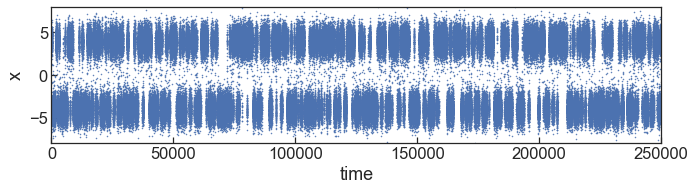

In [4]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(data[:,0],data[:,1],'.', markersize=1)
ax.set_ylim(-8,8)
ax.set_xlim(0,250000)
ax.set_ylabel('x')
ax.set_xlabel('time')
plt.tight_layout()

Clearly the system interconverts between two states. We can obtain a potential of mean force from a Boltzmann inversion of the probability distribution.

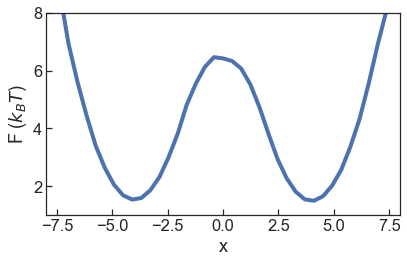

In [5]:
fig, ax = plt.subplots()
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-8,8,40),\
                               density=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist), lw=4)
ax.set_xlim(-8,8)
ax.set_ylim(1,8)
ax.set_xlabel('x')
_ = ax.set_ylabel('F ($k_BT$)')
plt.tight_layout()

Instead of defining two states using an arbitrary cutoff in our single dimension, we discretize the trajectory by assigning frames to microstates. In this case we use as microstates the indexes of a grid on x.

In [6]:
assigned_trj = list(np.digitize(data[:,1], bins=bin_edges))

In this way, the continuous coordinate x is mapped onto a discrete microstate space.

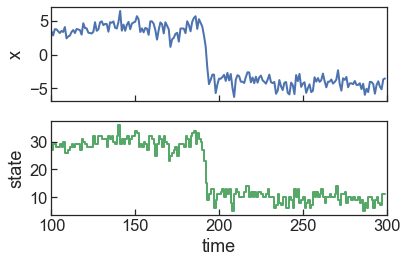

In [7]:
fig,ax=plt.subplots(2,1, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(100,len(data[:,1][:300])),data[:,1][100:300], lw=2)
ax[1].step(range(100,len(assigned_trj[:300])),assigned_trj[100:300], color="g", lw=2)
ax[0].set_xlim(100,300)
ax[0].set_ylabel('x')
ax[1].set_ylabel("state")
ax[1].set_xlabel("time")
plt.tight_layout()

We then pass the discrete trajectory to the ``traj`` module to generate an instance of the ``TimeSeries`` class. Using some of its methods, we are able to generate and sort the names of the microstates in the trajectory, which will be useful later.

In [8]:
from mastermsm.trajectory import traj
distraj = traj.TimeSeries(distraj=assigned_trj, dt=1)
distraj.find_keys()
distraj.keys.sort()

### Master Equation Model
After generating the discrete trajectory, we can build the master equation model, for which we use the ``msm`` module.

In [9]:
from mastermsm.msm import msm

First of all, we will create an instance of the `SuperMSM` class, which will be useful to produce and validate dynamical models. We pass two arguments: the "discrete trajectory" that we have generated above and a value for the boolean `sym`. This only tells the program that it can symmetrize the data, as we are assuming our trajectory is long enough as to consider it equilibrium sampling.

In [10]:
msm_1D = msm.SuperMSM([distraj], sym=True)

     # states: 39


After creating the `msm_1D` object, the program tells us that we are using 39 microstates.

For the simplest type of dynamical model validation, we carry out a convergence test to check that the relaxation times $\tau$ do not show a dependency on the lag time. For this, `MasterMSM` will automatically build MSMs at different lag times $\Delta$t. Each of them can be accessed as an instance of the `MSM` class.

In [11]:
for lt in [1, 2, 5, 10, 20, 50, 100]:
    msm_1D.do_msm(lt)
    msm_1D.msms[lt].do_trans(evecs=True)
    msm_1D.msms[lt].boots()

 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing


We then check the dependence of the slowest relaxation times of the system, $\tau$ with respect to the choice of lag time $\Delta t$. These can be accessed as the `tauT` corresponding to the `MSM` instance. We find that they are very well converged even from the shortest value of $\Delta t$.

In [16]:
tau_vs_lagt = np.array([[x,msm_1D.msms[x].tauT[0], \
                         msm_1D.msms[x].tau_std[0]] \
               for x in sorted(msm_1D.msms.keys())])

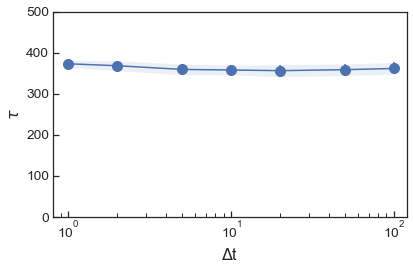

In [57]:
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', \
            yerr=tau_vs_lagt[:,2], markersize=10)
ax.fill_between(tau_vs_lagt[:,0],tau_vs_lagt[:,1]+tau_vs_lagt[:,2], \
                tau_vs_lagt[:,1]-tau_vs_lagt[:,2], alpha=0.1)
ax.set_xlabel(r'$\Delta$t', fontsize=16)
ax.set_ylabel(r'$\tau$', fontsize=16)
ax.set_xlim(0.8,120)
ax.set_ylim(0,500)
#ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

While this is not the most rigorous test we can do, it already gives some confidence on the dynamical model derived. We can inspect the count and transition matrices at even the shortest lag time.

In [26]:
lt = 1 # lag time
msm_1D.do_msm(lt)
msm_1D.msms[lt].do_trans(evecs=True)
msm_1D.msms[lt].boots()

 symmetrizing


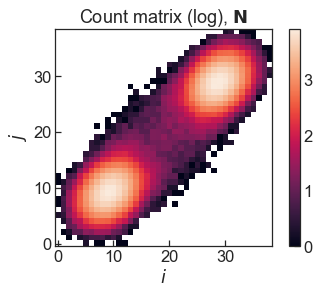

In [31]:
plt.figure()
plt.imshow(np.log10(msm_1D.msms[lt].count), interpolation='none', \
    origin='lower')
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.title('Count matrix (log), $\mathbf{N}$')
plt.colorbar()

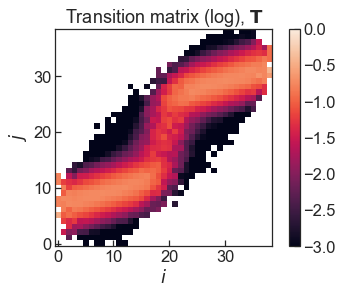

In [32]:
plt.figure()
plt.imshow(np.log10(msm_1D.msms[lt].trans), interpolation='none', \
    vmin=-3, vmax=0, origin='lower')
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.title('Transition matrix (log), $\mathbf{T}$')
_ = plt.colorbar()

Additionally, we can run a simple estimation of the rate matrix using the `do_lbrate()` method

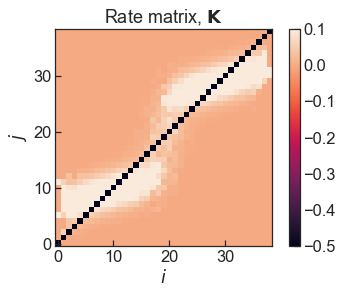

In [36]:
msm_1D.do_lbrate()
plt.figure()
plt.imshow(msm_1D.lbrate, interpolation='none', \
    origin='lower', vmin=-0.5, vmax=0.1)
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.title('Rate matrix, $\mathbf{K}$')
plt.colorbar()

### Analysis of the results 

Note that when were looking at the convergence of the slowest relaxation time of the model, we were ignoring the remainder of the spectrum of relaxation times, $\tau_i$. This system is expected to have a unique slow mode, corresponding to the barrier crossing process between the wells, and many fast modes separated by a consderable timescale gap. In fact, that is precisely what we find.

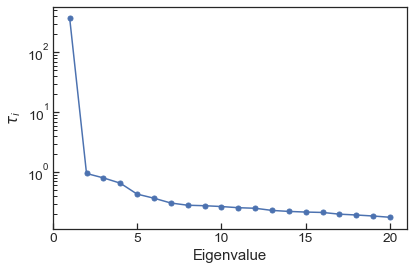

In [58]:
fig, ax = plt.subplots()
ax.errorbar(range(1, 21), msm_1D.msms[lt].tauT[:20], fmt='o-', \
            yerr=msm_1D.msms[lt].tau_std[:20], ms=5)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$')
ax.set_yscale('log')
ax.set_xlim(0,21)
plt.tight_layout()

From the eigenvectors we can also retrieve valuable information. The zeroth eigenvector, $\Psi^R_0$, which is stored as the `rvecsT` array, corresponds to the equilibrium distribution. The slowest mode in our model, captured by the first eigenvector $\Psi^R_1$, corresponds to the transition betweem the folded and unfolded states of the protein. The information of the left eigenvectors can be trivially transformed into that of the left eigenvectors, $\Psi^L_i$.

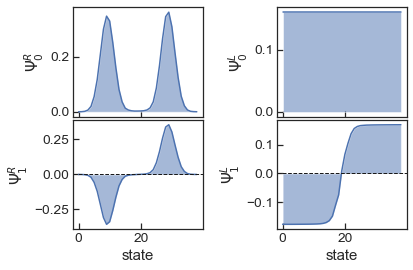

In [66]:
fig, ax = plt.subplots(2,2, sharex=True)
ax[0][0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0][0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)

ax[0][1].plot(-msm_1D.msms[1].lvecsT[:,0])
ax[0][1].fill_between(range(len(msm_1D.msms[1].lvecsT[:,0])), \
                   -msm_1D.msms[1].lvecsT[:,0], 0, alpha=0.5)

ax[1][0].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1][0].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1][0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)

ax[1][1].plot(msm_1D.msms[1].lvecsT[:,1])
ax[1][1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1][1].fill_between(range(len(msm_1D.msms[1].lvecsT[:,1])), \
                   msm_1D.msms[1].lvecsT[:,1], 0, alpha=0.5)

ax[1][0].set_xlabel("state")
ax[1][1].set_xlabel("state")
ax[0][0].set_ylabel("$\Psi^R_0$")
ax[1][0].set_ylabel("$\Psi^R_1$")
ax[0][1].set_ylabel("$\Psi^L_0$")
ax[1][1].set_ylabel("$\Psi^L_1$")
plt.tight_layout(h_pad=0)

### Calculation of committors
Using the method by Berezhkovskii, Hummer and Szabo ([*JCP*, 2009](https://aip.scitation.org/doi/abs/10.1063/1.3139063)), we calculate the value of the committor (or $p_{fold}$ in the context of protein folding), the probability that the system will go from to one state before going back to the other. For this we must first define microstates which are definitely one or the other, which we do with options ```FF``` and ```UU```.

In [84]:
msm_1D.msms[1].do_rate()
UU = list(range(8,12,1))
FF = list(range(28,32,1))
msm_1D.msms[1].do_pfold(FF=FF, UU=UU)

   definitely FF and UU states [7, 8, 9, 10, 27, 28, 29, 30]


In [85]:
msm_1D.msms[1].peqT


array([1.2000e-05, 6.4000e-05, 4.0400e-04, 1.5360e-03, 4.9080e-03,
       1.3820e-02, 2.9528e-02, 5.2476e-02, 7.5676e-02, 8.7636e-02,
       8.3152e-02, 6.3470e-02, 4.0216e-02, 2.0428e-02, 9.0560e-03,
       3.3160e-03, 1.6000e-03, 8.9600e-04, 6.4000e-04, 6.6800e-04,
       7.3200e-04, 9.5200e-04, 1.6400e-03, 3.5960e-03, 9.0640e-03,
       2.1712e-02, 4.2148e-02, 6.7000e-02, 8.7196e-02, 9.1272e-02,
       7.7888e-02, 5.4062e-02, 3.1340e-02, 1.4196e-02, 5.5040e-03,
       1.6360e-03, 4.2000e-04, 1.2400e-04, 1.6000e-05])

Text(0.5, 0, 'state')

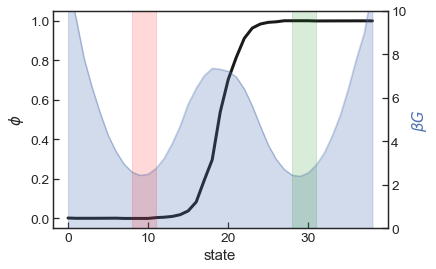

In [86]:
fig, ax = plt.subplots()

#ax.set_xlim(0,25)
axalt = ax.twinx()
axalt.plot(-np.log(msm_1D.msms[1].peqT), alpha=0.3, c='b')
axalt.fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   -np.log(msm_1D.msms[1].peqT), 0, alpha=0.25, color='b')
axalt.fill_between([FF[0], FF[-1]], \
                   10, 0, alpha=0.15, color='green')
axalt.set_ylim(0,10)
axalt.fill_between([UU[0], UU[-1]], \
                   10, 0, alpha=0.15, color='red')

ax.plot(msm_1D.msms[1].pfold, c='k', lw=3)
ax.set_ylabel('$\phi$')
axalt.set_ylabel(r'${\beta}G$', color='b')
ax.set_xlabel('state')

In [87]:
msm_1D.msms[1].do_pfold(FF=FF, UU=UU)
print (msm_1D.msms[1].kf)

   definitely FF and UU states [7, 8, 9, 10, 27, 28, 29, 30]
0.001355349204979408


### Sensitivity analysis
Using the methods described in De Sancho et al ([*JCTC*, 2015](https://dx.doi.org/10.1021/ct5011455)), we calculate the value of the sensitivity parameter, indicating the changes in the global rate  (actually, on $\ln(k_{UU\rightarrow FF}$)) upon changes in the free energy of each microstate.

In [88]:
msm_1D.msms[1].sensitivity(FF=FF, UU=UU)

   definitely FF and UU states [7, 8, 9, 10, 27, 28, 29, 30]


(-0.1, 0.1)

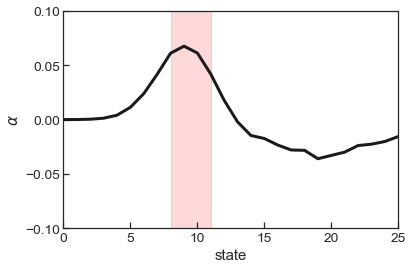

In [90]:
plt.plot(msm_1D.msms[1].d_lnkf, 'k', lw=3)
plt.fill_between([FF[0], FF[-1]], \
                   0.2, -0.1, alpha=0.15, color='green')

plt.fill_between([UU[0], UU[-1]], \
                   0.2, -0.1, alpha=0.15, color='red')

plt.xlabel('state')
plt.ylabel(r'$\alpha$')
plt.xlim(0,25)
plt.ylim(-0.1,0.1)

The result shows an increase of the global rate upon an increase of the free energy (destabilization) of microstates at the left of the barrier. Also, we find a dip for the states in the middle, corresponding to a  decrease